# Use REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import rebound
import dask.dataframe as dd
plt.style.use('paper')

In [12]:
csvpath = '../csvs/resonant/resonant_features/'
distpath = '../../stabilitydataset/data/resonant/simulation_archives/runs/'
df = pd.read_csv(csvpath + 'ressummaryfeatures.csv', index_col=0)
df = df[['ID', 'Mean', 'Sigma', 'KSpval']]
df.head()

,ID,Mean,Sigma,KSpval
3,3,6.837504,0.306543,0.403103
4,4,5.687568,0.239838,0.001330
5,5,5.797549,0.456784,0.930714
8,8,5.891151,0.417529,0.709091
13,13,4.644210,0.256174,0.000218


In [3]:
df.shape

(145, 4)

In [4]:
df = df[(df['Mean'] > 4) & (df['Mean'] < 7)]
df.shape

(136, 4)

In [5]:
labels = pd.read_csv('../../MLstability/training_data/resonant/labels.csv', index_col=0)
labels.head(15)

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.545872e+06,3.063700e+06,False
1,0000001.bin,9.990000e+08,9.990000e+08,True
2,0000002.bin,9.990000e+08,9.990000e+08,True
3,0000003.bin,2.287671e+06,8.392234e+06,False
4,0000004.bin,9.668931e+05,3.380350e+05,False
5,0000005.bin,5.755894e+05,5.459781e+04,False
6,0000006.bin,7.248372e+07,3.243220e+08,False
7,0000007.bin,2.225858e+04,6.193744e+03,False
8,0000008.bin,2.930966e+05,1.359759e+06,False
9,0000009.bin,3.484791e+05,9.534973e+05,False


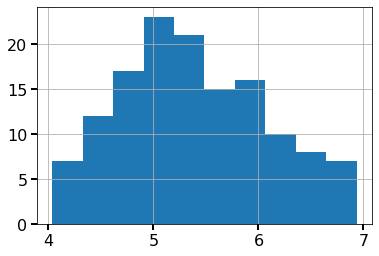

In [6]:
df['Mean'].hist()

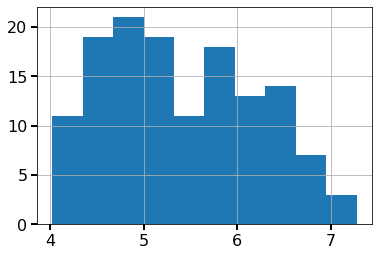

In [7]:
np.log10(labels.loc[df['ID']]['instability_time']).hist()

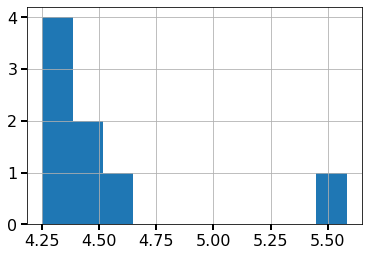

In [8]:
np.log10(labels.loc[df[df['KSpval'] < 1.e-6]['ID']]['instability_time']).hist()

In [38]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def run(row):
    tmax = 1e7
    ID = int(row['ID'])
    
    file = distpath+"sa{0:0=7d}.bin".format(ID)
    sim = rebound.SimulationArchive(file)[0]
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)
    
    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P
    megnos, tlyaps = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time, exact_finish_time=0)
        except:
            break
        megnos[i] = sim.calculate_megno()
        tlyaps[i] = 1/sim.calculate_lyapunov()/P0
        
    nonzero = int((megnos > 0).sum())
    megnos = megnos[:nonzero]
    tlyaps = tlyaps[:nonzero]
    row['tlyap'] = tlyaps[~np.isnan(tlyaps)][-1]
    if row['tlyap'] < 0 or row['tlyap'] > sim.t:
        row['tlyap'] = sim.t
    row['megno'] = megnos[~np.isnan(megnos)][-1]
    row['megnonan'] = np.isnan(megnos[-1])
    row['instability_time'] = labels.loc[ID, 'instability_time']
    row['Nlyap'] = row['instability_time']  / row['tlyap']
    return row

def runsplit(row):
    tmax = 1e7
    ID = int(row['ID'])
    row['instability_time'] = labels.loc[ID, 'instability_time']

    file = distpath+"sa{0:0=7d}.bin".format(ID)
    sim = rebound.SimulationArchive(file)[0]
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)

    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P

    try:
        sim.integrate(row['instability_time']/10, exact_finish_time=0)
        row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
        if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
            row['tlyap10'] = sim.t
        row['megno10'] = sim.calculate_megno()
        row['Nlyap10'] = row['instability_time']  / row['tlyap10']
    except:
        row['tlyap10'] = np.nan
        row['megno10'] = np.nan
        row['Nlyap10'] = np.nan
    
    return row

# We don't get exactly the same instability time when rerunning stopping along the way because the original integrations are using unsynced positions to detect collisions and megno syncs them. But that's fine. We always get very close, because it's once the orbits are crossing that we start finding collisions (synced or unsynced). This is a demonstration that the exact details of detecting collisions doesn't matter. We've also already checked reproducibility when we do a single sim.integrate (see test_notebooks) and here we just want the lyap times

In [36]:
row = df.loc[223]
tmax = 1e7
ID = int(row['ID'])
row['instability_time'] = labels.loc[ID, 'instability_time']

file = distpath+"sa{0:0=7d}.bin".format(ID)
sim = rebound.SimulationArchive(file)[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.collision_resolve=collision
sim.init_megno(seed=0)

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
P0 = sim.particles[1].P

sim.integrate(row['instability_time']/3, exact_finish_time=0)
row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
    row['tlyap10'] = sim.t
row['megno10'] = sim.calculate_megno()
row['Nlyap10'] = row['instability_time']  / row['tlyap10']
sim.t/P0

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Escape: User caused exit. Simulation did not finish.

In [35]:
labels.loc[ID, 'instability_time']

11584.51005717814

# Generate

In [39]:
%%time
ddf = dd.from_pandas(df, npartitions=24)
testres = runsplit(df.iloc[0])
df = ddf.apply(runsplit, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWit

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/work

CPU times: user 17.1 s, sys: 883 ms, total: 18 s
Wall time: 4min 32s


In [40]:
df.to_csv(csvpath+'res1e7featuressplit.csv')

In [27]:
ddf

,ID,Mean,Sigma,KSpval
npartitions=21,,,,
3,int64,float64,float64,float64
19,...,...,...,...
...,...,...,...,...
261,...,...,...,...
266,...,...,...,...


In [28]:
df.loc[223]

ID        2.420000e+02
Mean      2.903427e+00
Sigma     8.908058e-01
KSpval    4.330748e-08
Name: 223, dtype: float64